In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import torch

from archetypal import UmiTemplateLibrary
from ladybug.epw import EPW 
from lightning.pytorch import Trainer

from ml.data import BuildingDataModule
from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from umi.ubem import UBEM

Couldn't import dot_parser, loading of dot files will not be possible.


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.8.17
[Taichi] Starting on arch=cuda


In [2]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v5"
local_data_dir = "data/lightning"

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v1"
resource = "model-with-transform-configs.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="cpu",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:

# gdf = gpd.read_file(Path("data") / "gis" / "Florianopolis_Baseline_sam.zip")

# # dict to store key fields for known gis files
# id_cols = {
#     "florianpolis": {
#         "height_col": "HEIGHT",
#         "id_col": "OBJECTID",
#         "template_name_col": "template_name",
#         "wwr_col": "wwr",
#     }
# }

# epw_fp = (
#     Path("data")
#     / "epws"
#     / "global_epws_indexed"
#     / "cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Data.epw"
#     # / "cityidx_0007_USA_IL-Chicago Midway.725340_TMY--14819.epw"
# )

# epw = EPW(epw_fp)
# template_lib = UmiTemplateLibrary.open(
#     Path("data") / "template_libs" / "BostonTemplateLibrary.json"
# )

# # Insert dummy template names
# gdf[id_cols["florianpolis"]["template_name_col"]] = np.random.choice(
#     [t.Name for t in template_lib.BuildingTemplates], size=gdf.shape[0]
# )
# # insert dummy wwrs
# gdf[id_cols["florianpolis"]["wwr_col"]] = 0.4

# # umi_test = UBEM(
# #     gdf=gdf,
# #     **id_cols["florianpolis"],
# #     epw=epw,
# #     template_lib=template_lib,
# #     shoebox_width=3,
# #     floor_to_floor_height=4,
# #     perim_offset=4,
# # )

# umi_test = UBEM.open_umi(Path("data") / "gis" / "seed_ulaanbataar.umi", id_col="id", height_col="Height")

In [3]:
# umi_test = UBEM.open_umi(Path("C:/Users/szvsw/Downloads/umi_tester_boston.umi"), id_col="id", height_col="Height")
umi_test = UBEM.open_umi(Path("data") / "gis" / "seed_ulaanbataar.umi", id_col="id", height_col="Height")

INFO:UMI:reading input file...
DEBUG:UMI:TEMPORARY LOCATION C:\Users\szvsw\AppData\Local\Temp\tmp9f35ihdf
INFO:UMI:Successfully loaded EPW file Data for [ULAANBATAAR]
DEBUG:UMI:['sdl-common/district_energy_scenarios.json', 'sdl-common/planningSettings.json', 'sdl-common/project.json', 'sdl-common/shoebox-weights.json', 'sdl-common/site-analysis-settings.json', 'sdl-common/ThermalPlantSettings.json', 'sdl-common/ubemio-archetype-id-cache.json', 'sdl-common/ud-results.xml', 'sdl-common/project-settings.json', 'sdl-common/project-header.json', 'Florianopolis_Baseline.3dm', 'cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Data.epw', 'template-library.json', 'umi.sqlite3']
INFO:UMI:Opening archetpal templates at template-library.json
DEBUG:UMI:Index(['id', 'FloorCount', 'GrossFloorArea', 'Height', 'Name', 'Occupancy',
       'TemplateName', 'UseType', 'WwrE', 'WwrN', 'WwrS', 'WwrW', 'geometry'],
      dtype='object')
INFO:UMI:Read 9.8KB from data\gis\seed_ulaanbataar.umi in 0.28 seconds
INFO:UMI

KeyError: "['WindowToWallRatioN'] not in index"

In [141]:

umi_test.prepare_epw_features(epw=EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw"))
features, schedules, climate = umi_test.prepare_for_surrogate()
features["WindowShgc"] = 0.9
features["WindowUValue"] = 5.94
features["VentilationMode"] = 1
features["EquipmentPowerDensity"] = 2.5
# features["LightingPowerDensity"] = 5
features["RoofRValue"] = 2.6
features["FacadeRValue"] = 1.9
features["FacadeMass"] = 1
features["RoofMass"] = 1
features["SlabRValue"] = 0.3
features["Infiltration"] = 0.0005
features["wwr"] = 0.45
features["width"] = 3
features["core_2_perim"] = 0.76
features[[col for col in features.columns if "shading" not in col]]

torch.set_float32_matmul_precision("medium")
shoebox_predictions, monthly_predictions, annual_predictions = predict_ubem(
        trainer=trainer,
        surrogate=surrogate,
        features=features,
        schedules=schedules,
        climate=climate,
        batch_size=32,
        apply_cops=True
    )
annual_predictions

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 27/27 [00:01<00:00, 23.11it/s]


Name,Cooling,Heating
building_id,,
027e56c0-34b7-714a-9e97-08db9fc15045,32.908970,101.731266
095ce372-1a56-5744-a7be-6350e9250916,3.019481,246.386669
0a11abfe-8782-a241-a8c0-20bd08f70dbb,39.110348,122.254172
11ed3672-e6fb-354f-9f76-fc3e8fbcd50b,39.138910,122.234302
12f9435e-d5cc-bd40-9efa-c6ec52a9f804,9.091539,159.535539
...,...,...
f7639920-472d-684e-ad8c-58d9e3e47d8d,15.921632,117.540639
f897dfda-495c-fa4c-b699-838a134581a9,7.960876,183.534718
fa78e0aa-51dd-9448-a581-d403fbf76a4e,10.777585,225.067488


In [136]:
shoebox_annual = shoebox_predictions.T.groupby(level=[0,1]).sum().T
shoebox_annual["Core"]["Cooling"] /= 3
shoebox_annual["Core"]["Heating"] /= 0.8
shoebox_annual["Perimeter"]["Cooling"] /= 3
shoebox_annual["Perimeter"]["Heating"] /= 0.8
perim_depth = umi_test.perim_offset
df = (shoebox_annual["Core"] * perim_depth*features.core_2_perim.values.reshape(-1,1) + shoebox_annual["Perimeter"] * perim_depth) / (perim_depth+perim_depth*features.core_2_perim.values.reshape(-1,1))
df["orientation"] = features["orientation"].values
df["floor_name"] = features["floor_name"].values
# df[(df["floor_name"] == "bottom" ) & (df["orientation"] == "east")]
df = df.sort_values(by=["floor_name", "orientation"])
df["orientation"] = df["orientation"].apply(lambda x: ["south", "east", "north", "west"][x])
df

true_cooling = np.array([9,6.5,1.55,8.61,23,21,10,23,17,17,8.9,19])
true_heating = np.array([43,56,69,56,18,48,70,44,76,119,148,115])
np.abs((true_cooling - df["Cooling"].values)).mean()
np.abs((true_heating - df["Heating"].values)).mean()
elec_add_in = 0
total = (true_cooling+true_heating+elec_add_in)
total_pred = (df["Cooling"].values+df["Heating"].values+elec_add_in)
(np.abs(total - total_pred)**2).mean()**0.5 / (total.mean())
(np.abs(total-total_pred) / total).mean()
np.abs(total.mean()- total_pred.mean()) / total.mean()

0.1616811516187576

In [137]:
df

Name                                       Cooling     Heating orientation  \
building_id                                                                  
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c 8    7.191793   15.131004       south   
                                     0    9.505059   43.091584        east   
                                     4    2.254479   60.948079       north   
                                     12   9.548363   45.130214        west   
                                     9   22.128784   10.258557       south   
                                     1   23.053423   33.489728        east   
                                     5   10.910588   52.587622       north   
                                     13  23.171582   34.930406        west   
                                     10  16.391448   64.250706       south   
                                     2   19.071791   99.956298        east   
                                     6    9.339433  125.413194       north   
                                     14  18.998114  103.832346        west   

Name                                    floor_name  
building_id                                         
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c 8      bottom  
                                     0      bottom  
                                     4      bottom  
                                     12     bottom  
                                     9      middle  
                                     1      middle  
                                     5      middle  
                                     13     middle  
                                     10        top  
                                     2         top  
                                     6         top  
                                     14        top

In [130]:
df_old

Name                                       Cooling     Heating orientation  \
building_id                                                                  
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c 8   10.094458   19.395237       south   
                                     0   13.467731   54.014703        east   
                                     4    3.431132   78.134102       north   
                                     12  13.270586   57.171684        west   
                                     9   28.609388   13.845724       south   
                                     1   29.736799   44.100200        east   
                                     5   13.003355   70.716552       north   
                                     13  29.419922   46.873219        west   
                                     10  21.035337   63.592982       south   
                                     2   24.727658  108.629785        east   
                                     6   11.371634  142.408786       north   
                                     14  24.407730  113.745801        west   

Name                                    floor_name  
building_id                                         
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c 8      bottom  
                                     0      bottom  
                                     4      bottom  
                                     12     bottom  
                                     9      middle  
                                     1      middle  
                                     5      middle  
                                     13     middle  
                                     10        top  
                                     2         top  
                                     6         top  
                                     14        top

Text(0.5, 0, 'Climate Studio [kWh/m2]')

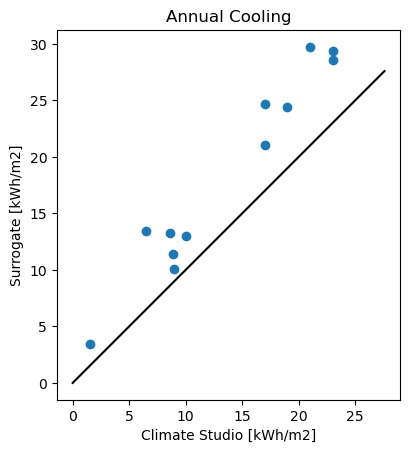

In [123]:
import matplotlib.pyplot as plt

plt.scatter(true_cooling, df["Cooling"].values)
plt.plot([0,true_cooling.max()*1.2],[0,true_cooling.max()*1.2], color="black")
plt.gca().set_aspect("equal")
plt.title("Annual Cooling")
plt.ylabel("Surrogate [kWh/m2]")
plt.xlabel("Climate Studio [kWh/m2]")

In [8]:
core_heating = (
    np.array(
        [
            160,
            216,
            239,
            1316,
        ]
    )
    / 100
)

core_cooling = (
    np.array(
        [
            1358,
            1635,
            575,
            1521
        ]
    )
    / 100
)


core_cooling, core_heating

(array([13.58, 16.35,  5.75, 15.21]), array([ 1.6 ,  2.16,  2.39, 13.16]))

In [6]:
features[[ "floor_name","weight","orientation"]]

,floor_name,weight,orientation
0,bottom,0.083333,1
1,middle,0.166667,1
2,top,0.083333,1
4,bottom,0.041667,2
5,middle,0.083333,2
6,top,0.041667,2
8,bottom,0.041667,0
9,middle,0.083333,0
10,top,0.041667,0
12,bottom,0.083333,3


In [14]:
shoebox_predictions["Perimeter"]["Cooling"].sum(axis=1) / 3

building_id                             
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c  0     30.411108
                                      1     45.787739
                                      2     41.576351
                                      4     29.609213
                                      5     44.848309
                                      6     40.492950
                                      8     29.086435
                                      9     50.942692
                                      10    41.837627
                                      12    10.387435
                                      13    20.893934
                                      14    19.126724
dtype: float32

In [7]:

shoebox_predictions["Core"]["Cooling"].sum(axis=1) / 3

building_id                             
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c  0     14.166623
                                      1     29.214315
                                      2     25.757133
                                      4     14.499660
                                      5     29.144798
                                      6     25.922554
                                      8     12.282940
                                      9     31.331978
                                      10    24.785196
                                      12     5.856478
                                      13    17.402552
                                      14    15.721725
dtype: float32

In [8]:

shoebox_predictions["Perimeter"]["Heating"].sum(axis=1) / 0.9

building_id                             
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c  0     19.654510
                                      1     13.356274
                                      2     31.087294
                                      4     22.890020
                                      5     15.893867
                                      6     34.303768
                                      8      0.992057
                                      9      0.428594
                                      10     8.372170
                                      12    38.363194
                                      13    30.974041
                                      14    54.271023
dtype: float32

In [9]:
shoebox_predictions["Core"]["Heating"].sum(axis=1) / 0.9

building_id                             
4b48fce5-e86f-45d3-be47-7a9b0d7d0e2c  0      3.923172
                                      1      1.267397
                                      2     13.127552
                                      4      5.033083
                                      5      1.538902
                                      6     14.833230
                                      8      0.000000
                                      9      0.000000
                                      10     2.126935
                                      12    10.856131
                                      13     6.013148
                                      14    24.685547
dtype: float32

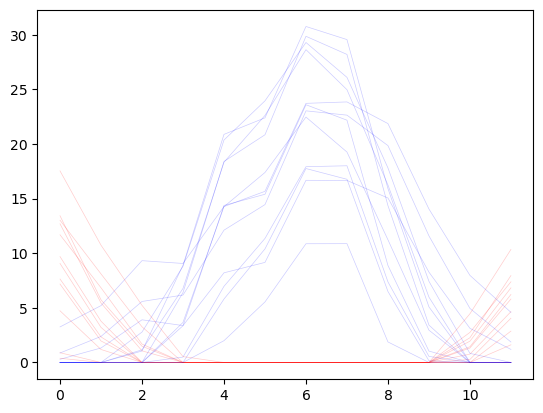

In [10]:
cooling = shoebox_predictions["Perimeter"]["Cooling"].values
heating = shoebox_predictions["Perimeter"]["Heating"].values
archetype = features.template_idx.values
colors = ["red","blue","green","yellow","orange","purple","pink","brown","black","grey"]
import matplotlib.pyplot as plt
for i in range(len(cooling)):
    plt.plot(heating[i],c="red", lw=0.5, alpha=0.2)
    plt.plot(cooling[i],c="blue", lw=0.5, alpha=0.2)

array([[<Axes: title={'center': 'Cooling'}>,
        <Axes: title={'center': 'Heating'}>]], dtype=object)

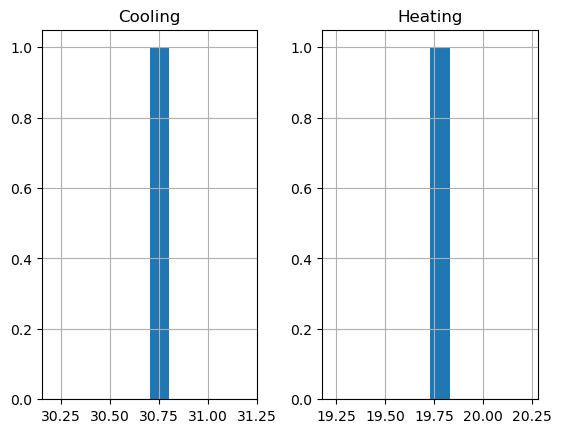

In [11]:
annual_predictions.hist()

In [12]:
hourly = pd.read_csv("data/SeedValidation/seed_ulaanbataar_heating.csv")[[str(i) for i in range(1, 8761) ]]
og = pd.read_csv("data/SeedValidation/seed_ulaanbataar_heating.csv")["Building Id"]

template_ids = features.set_index("building_id").loc[og, "template_idx"]

for i in range(len(hourly)):
    plt.plot(hourly.iloc[i].values,c=colors[template_ids.iloc[i]], lw=0.5, alpha=0.2)


KeyError: "None of [Index(['027e56c0-34b7-714a-9e97-08db9fc15045',\n       '095ce372-1a56-5744-a7be-6350e9250916',\n       '0a11abfe-8782-a241-a8c0-20bd08f70dbb',\n       '11ed3672-e6fb-354f-9f76-fc3e8fbcd50b',\n       '12f9435e-d5cc-bd40-9efa-c6ec52a9f804',\n       '1593071f-0654-f548-9e88-7c19a0035652',\n       '184d2650-2966-1e49-807a-85e051d107a7',\n       '1ad6ac2d-9542-c042-aacb-8931a225288f',\n       '1b489621-09c7-c04c-84ba-813c4908d14a',\n       '1bffad21-b8d4-0145-8a71-abe97df905ed',\n       '1c28c7af-3ca2-3f42-ab49-54e2b75eba39',\n       '1ca2f3b1-ec97-8d48-9a71-4ec991aa5622',\n       '1cf6c185-9ef9-984f-bb1d-0faa206a5dd9',\n       '1d83cbc6-e4e0-e147-b2cc-923bdad660fc',\n       '1fc83084-9e4c-3a4f-9efe-2030f29f3854',\n       '256a3447-71e0-7943-b6ef-5de308106b12',\n       '2751d01d-c4ab-fb4f-b7ff-23be1e79ec72',\n       '2c0846f9-737b-544d-9feb-82b06fe0257e',\n       '2c6f9b46-92e1-d341-8bee-33b5fd917154',\n       '2ceeb525-d784-da41-84fc-0f11df21e1ec',\n       '2e86eafd-7bd2-0c4d-804a-5b2cdde6004a',\n       '30abb9d5-6cd7-894a-a727-17a77c1edac5',\n       '31a1b53a-fe81-6846-bf7d-440461f528c8',\n       '324fc016-c43a-4841-a5cf-165de68efb12',\n       '34e4c35f-adf5-ca40-b8cd-b77911362c41',\n       '36b7227d-165c-244e-8a8b-62edaf01e042',\n       '37f069f2-9f66-f547-bde6-12317abb51b7',\n       '3a22c251-98b4-3849-bfdc-367f06e00d3a',\n       '3bad65c4-50f0-b244-973c-b7e64a67f960',\n       '41391093-5407-0a43-9cc6-312e66fcdd76',\n       '4b1eb46c-689f-8b45-b8f4-b75d54c4b8ba',\n       '500873bd-b651-254f-9970-a884b0323708',\n       '516258c6-6838-e447-97c3-399397cb2691',\n       '551e87c2-9a4f-d44b-9341-53cde7640265',\n       '5857fa71-f39e-1c43-b4c0-1fc28efbac7c',\n       '5b9a64cf-cfbc-4046-86d8-5e926878cd5f',\n       '5cdbf518-450d-c248-91cc-6d9daf651628',\n       '5d69840b-b24c-5447-88bc-6977c0672ede',\n       '64287b3b-6c63-7540-9c7d-52780060f56f',\n       '663e3324-ce20-6d43-b76d-f42ae71c9730',\n       '68221794-bb08-8c42-a136-8923a02d697c',\n       '6a7ec1fb-826a-b648-90af-84a089d66987',\n       '6ad84156-47c8-6f4f-9f52-d1bcb6aa485c',\n       '6b9bb478-9313-f249-8aa8-8faaf46b84bc',\n       '6d9eb66e-261e-8b4b-8450-4b8447efca2d',\n       '700fbf1e-2a71-4c43-bf16-fdb82b07c421',\n       '739cd930-929f-f446-9cbd-1057856e207c',\n       '762e8cad-394b-cf41-ad18-87bb496f4efd',\n       '7e60cfa3-a55c-6b4b-b72a-171edb7fbaa6',\n       '8409615a-ec3d-4947-b940-9db66732dd4b',\n       '85659c25-cd74-0642-bcdb-5ed868323669',\n       '8871aa84-b57c-9a46-a2ef-ccb8edbbac00',\n       '8908ce9f-c42c-174a-a886-abcdd2605401',\n       '8b451d08-3023-1542-973f-5c1849a95221',\n       '8ee77af5-42b1-574e-8fd6-6d6d8d2637e2',\n       '9d3515d1-1455-164b-a81c-32f4441086f1',\n       '9deada88-0db8-3346-a76a-61cb7c134312',\n       'a896ccfc-4a52-5d43-bb89-118f2b1d1dc6',\n       'ab431a51-108f-f640-9a21-c4b6f9bdf628',\n       'add662a8-efa9-2c49-8d54-66b826d722b5',\n       'b22d4787-2653-2147-851e-ded8e4386bd6',\n       'b5462178-646d-3946-89fb-202889a0595d',\n       'b6e6f9fe-b088-7642-9b39-b1c16dd45095',\n       'b841e360-a954-404c-b518-f7a5ab344285',\n       'b8848bab-34b8-6b44-bb4c-43deca1051a6',\n       'ba797bc2-0755-064e-95bc-c0fda173f22c',\n       'c01d47eb-099f-d548-b919-f634261aff69',\n       'c5d03a7e-c302-2a45-b36e-50d81895ad70',\n       'c86941f4-5fc5-9946-8497-895f2318e922',\n       'cc68d2e7-a7b1-374f-a43d-1baabce2fc43',\n       'd3754066-bf9b-1744-aed5-9ae610cdb341',\n       'd435e29a-dc7f-704e-9099-d1cb82bd3d0d',\n       'd5202d3c-aa06-4744-ab26-290ef127b86d',\n       'd6805327-9398-ae49-80af-ce33175b11e5',\n       'd6ec0541-f000-5d41-837b-af6b003aa856',\n       'd77f75ff-1c8b-d14a-bdae-a1263e35cdcb',\n       'd9ece0ea-55b5-5e40-bf72-ef739c01499b',\n       'da19ecf3-2f64-de4b-a2dc-9798d6489dfb',\n       'db8376fd-5c7c-284d-a043-ab3296b02152',\n       'de323b3c-1bdc-7243-aea6-35a270be2c72',\n       'e0a4fb87-fb20-e74e-b54e-cbb400e1c563',\n       'e3af0c0f-8444-e14e-8efd-60099ae9cf3e',\n       'ec130638-fd8b-7348-abcd-dc4e21700f70',\n       'ef6ba824-9df4-b54d-ae5f-8a440209dd66',\n       'ef96fb96-2394-9f40-b12b-4cf5963b7533',\n       'f066562e-fe9b-9345-b7cf-dc9445b91366',\n       'f546ecbc-7ffa-6743-ba05-b1a8b823c126',\n       'f67e2387-69ac-3f42-ade8-163f3b781655',\n       'f7639920-472d-684e-ad8c-58d9e3e47d8d',\n       'f897dfda-495c-fa4c-b699-838a134581a9',\n       'fa78e0aa-51dd-9448-a581-d403fbf76a4e',\n       'fdc546fe-149f-3b41-8136-f5a870ada816',\n       'fe2d3c15-aa01-a34e-96d7-fc65ea3211cf'],\n      dtype='object', name='building_id')] are in the [index]"